In [1]:
from langchain.agents import create_openai_functions_agent
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

def create_agent(client, tools, prompt):
    return create_openai_functions_agent(client, tools, prompt)

def agent_excute(agent_outcome, tools):
    tool_executor = ToolExecutor(tools)
    return tool_executor.invoke(agent_outcome)

def is_agent_finish(agent_outcome):
    return isinstance(agent_outcome, AgentFinish)

In [2]:
# 모델 파라미터 설정
def langchain_param():
    params = {
        "temperature": 0.7,         # 생성된 텍스트의 다양성 조정
        "max_tokens": 500,          # 생성할 최대 토큰 수
        "frequency_penalty": 0.5,   # 이미 등장한 단어의 재등장 확률
        "presence_penalty": 0.5,    # 새로운 단어의 도입을 장려
    }
    return params

In [3]:
from langchain_openai import ChatOpenAI
import streamlit as st

@st.cache_resource
def get_client(model_id: str = "gpt-4o-mini"):
    try:
        return ChatOpenAI(model=model_id, **langchain_param())
    except Exception as e:
        st.error(f"ChatOpenAI를 불러오지 못했습니다.: {e}")
        return None


In [4]:
from typing import TypedDict, Annotated, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    input: str
    # 대화 내용 중 '이전 메시지' 목록
    chat_history: list[BaseMessage] 
    # 유효한 유형으로 `None`이 필요
    agent_outcome: Union[AgentAction, AgentFinish, None] 
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [5]:
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate

def get_prompt():
    prompt = hub.pull("hwchase17/openai-functions-agent")

    # 또는 PromptTemplate 객체와 결합하려면 아래와 같이 하세요
    additional_prompt = ChatPromptTemplate.from_template("\n\nYou are a helpful assistant. You must answer in Korean.")
    formatted_prompt = additional_prompt.format()  # 템플릿을 실제 텍스트로 변환

    # 두 텍스트를 결합하려면
    combined_prompt = prompt + formatted_prompt

    return combined_prompt


In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain.tools.retriever import create_retriever_tool

def get_retriever_tool():
    file_path = "C:\dev\github\SKN03-4th-2Team\SKN03-4th-2Team\PJY_MiniProject\data\다이어트.txt"
    # 파일의 경로 입력
    loader = TextLoader(file_path, encoding='utf-8')
    # 텍스트 분할기를 사용하여 문서를 분할합니다.
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

    # 문서를 로드하고 분할합니다.
    split_docs = loader.load_and_split(text_splitter)

    # VectorStore를 생성, 임베딩
    vector = FAISS.from_documents(split_docs, OpenAIEmbeddings())

    # Retriever를 생성합니다.
    retriever = vector.as_retriever()

    retriever_tool = create_retriever_tool(
        retriever,
        name="txt_search",
        description="다이어트 관련 질문은 이 유능한 다이어트 챗봇에 부탁드릴게요",
    )
    return retriever_tool

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\USER\AppData\Local\Temp\ipykernel_19664\2469746211.py:8: SyntaxWarning: invalid escape sequence '\d'
  file_path = "C:\dev\github\SKN03-4th-2Team\SKN03-4th-2Team\PJY_MiniProject\data\다이어트.txt"


In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
# TavilySearchResults 클래스의 인스턴스를 생성합니다
# k=5은 검색 결과를 5개까지 가져오겠다는 의미입니다
from dotenv import load_dotenv

load_dotenv("C:\\dev\\github\\SKN03-4th-2Team\\SKN03-4th-2Team\\PJY_MiniProject\\.env")

search = TavilySearchResults(
    max_results=6,
    include_answer=True,
    include_raw_content=True,
    include_domains=["github.io", "wikidocs.net"],
)

def get_tools():
    return [search, get_retriever_tool()]

In [8]:
from langgraph.graph import StateGraph, END
from langchain_core.agents import AgentFinish
from IPython.display import Image, display

def build_workflow(agent_runnable):
    def run_agent(data):
        return {"agent_outcome": agent_runnable.invoke(data)}

    def execute_tools(data):
        agent_action = data['agent_outcome']
        output = agent_excute(agent_action, get_tools())
        return {"intermediate_steps": [(agent_action, str(output))]}

    def should_continue(data):
        if isinstance(data['agent_outcome'], AgentFinish):
            return "end"
        else:
            return "continue"

    workflow = StateGraph(state_schema=AgentState)
    workflow.add_node("agent", run_agent)
    workflow.add_node("action", execute_tools)
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "continue": "action",
            "end": END
        }
    )
    workflow.add_edge('action', 'agent')
    
    return workflow


2024-11-06 19:29:12.275 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 19:29:12.476 
  command:

    streamlit run c:\dev\github\SKN03-4th-2Team\SKN03-4th-2Team\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-11-06 19:29:12.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 19:29:12.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 19:29:12.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-06 19:29:12.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
C:\Users\USER\AppData\Local\Temp\ipykernel_19664\1188859961.py:9: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and 

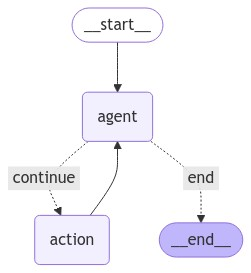

In [9]:
from IPython.display import Image

prompt = "다이어트 방법좀 알려줘"
message_history = []
message_history.append(
    {
        "role": "user",
        "content": prompt
    }
)

tools = get_tools()
agent_runnable = create_agent(get_client(), tools, get_prompt())

inputs = {
    "input": prompt,
    "chat_history": message_history,
    "intermediate_steps": []
}

# 에이전트 실행
agent_outcome = agent_runnable.invoke(inputs)

# 에이전트 완료 상태 확인
if is_agent_finish(agent_outcome):
    agent_outcome.return_values['output']

output = agent_excute(agent_outcome, tools)

# 상태 그래프 설정 및 실행
workflow = build_workflow(agent_runnable)
app = workflow.compile()
output = app.invoke(inputs)

display(Image(app.get_graph().draw_mermaid_png()))
